In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [ ]:
df = pd.read_csv('../content/drive/MyDrive/BD/GOOG-year.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-10-11,98.250000,100.120003,97.250000,98.050003,98.050003,21617700
1,2022-10-12,98.269997,99.648003,97.669998,98.300003,98.300003,17343400
2,2022-10-13,95.930000,100.529999,95.269997,99.709999,99.709999,32812200
3,2022-10-14,100.625000,101.290001,97.029999,97.180000,97.180000,22624800
4,2022-10-17,99.519997,101.769997,99.510002,100.779999,100.779999,23311600


In [ ]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.250129
1,0.254424
2,0.278646
3,0.235183
4,0.297028


In [ ]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((252, 7), (222, 1), (30, 1))

In [ ]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        backward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        forward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop_backward = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells, output_keep_prob = forget_bias
        )
        forward_backward = tf.contrib.rnn.DropoutWrapper(
            forward_rnn_cells, output_keep_prob = forget_bias
        )
        self.backward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        self.forward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        _, last_state = tf.nn.bidirectional_dynamic_rnn(
            forward_backward,
            drop_backward,
            self.X,
            initial_state_fw = self.forward_hidden_layer,
            initial_state_bw = self.backward_hidden_layer,
            dtype = tf.float32,
        )

        with tf.variable_scope('decoder', reuse = False):
            backward_rnn_cells_decoder = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
            )
            forward_rnn_cells_decoder = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            drop_backward_decoder = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells_decoder, output_keep_prob = forget_bias
            )
            forward_backward_decoder = tf.contrib.rnn.DropoutWrapper(
                forward_rnn_cells_decoder, output_keep_prob = forget_bias
            )
            self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
                forward_backward_decoder, drop_backward_decoder, self.X,
                initial_state_fw = last_state[0],
                initial_state_bw = last_state[1],
                dtype = tf.float32
            )
        self.outputs = tf.concat(self.outputs, 2)
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [ ]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta
from tqdm import tqdm

def forecast():
    model = Sequential()
    model.add(LSTM(size_layer, input_shape=(timestamp, df_log.shape[1]), return_sequences=True))
    model.add(LSTM(size_layer, return_sequences=True))
    model.add(Dense(df_log.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')

    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc='train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.zeros((1, timestamp, df_train.shape[1]))
            batch_x[0, :index - k, :] = df_train.iloc[k : index, :].values
            batch_y = np.zeros((1, timestamp, df_train.shape[1]))
            batch_y[0, :index - k, :] = df_train.iloc[k + 1 : index + 1, :].values
            loss = model.train_on_batch(batch_x, batch_y)
            total_loss.append(loss)
            pbar.set_postfix(cost=np.mean(total_loss))

    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0].values
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits = model.predict(df_train.iloc[k : k + timestamp, :].values.reshape(1, timestamp, -1))
        output_predict[k + 1 : k + timestamp + 1] = out_logits[0]

    if upper_b != df_train.shape[0]:
        out_logits = model.predict(df_train.iloc[upper_b:, :].values.reshape(1, df_train.shape[0] - upper_b, -1))
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits[0]
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days=1))

    init_value = out_logits[0]

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits = model.predict(o.reshape(1, timestamp, -1))
        output_predict[-future_day + i, :] = out_logits[0, -1, :]
        date_ori.append(date_ori[-1] + timedelta(days=1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]


In [ ]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1


train loop: 100%|██████████| 300/300 [05:28<00:00,  1.09s/it, cost=0.00174]


1/1 [==============================] - 0s 23ms/step
simulation 2


train loop: 100%|██████████| 300/300 [05:23<00:00,  1.08s/it, cost=0.00182]


1/1 [==============================] - 0s 36ms/step
simulation 3


train loop: 100%|██████████| 300/300 [05:26<00:00,  1.09s/it, cost=0.0018]


1/1 [==============================] - 0s 41ms/step
simulation 4


train loop: 100%|██████████| 300/300 [05:15<00:00,  1.05s/it, cost=0.00171]


1/1 [==============================] - 0s 35ms/step
simulation 5


train loop: 100%|██████████| 300/300 [05:26<00:00,  1.09s/it, cost=0.00176]


1/1 [==============================] - 0s 23ms/step
simulation 6


train loop: 100%|██████████| 300/300 [05:18<00:00,  1.06s/it, cost=0.00179]


1/1 [==============================] - 0s 34ms/step
simulation 7


train loop: 100%|██████████| 300/300 [05:11<00:00,  1.04s/it, cost=0.00176]


1/1 [==============================] - 0s 23ms/step
simulation 8


train loop: 100%|██████████| 300/300 [05:20<00:00,  1.07s/it, cost=0.0018]


1/1 [==============================] - 0s 29ms/step
simulation 9


train loop: 100%|██████████| 300/300 [05:20<00:00,  1.07s/it, cost=0.00174]


1/1 [==============================] - 0s 24ms/step
simulation 10


train loop: 100%|██████████| 300/300 [05:17<00:00,  1.06s/it, cost=0.00181]


1/1 [==============================] - 0s 41ms/step


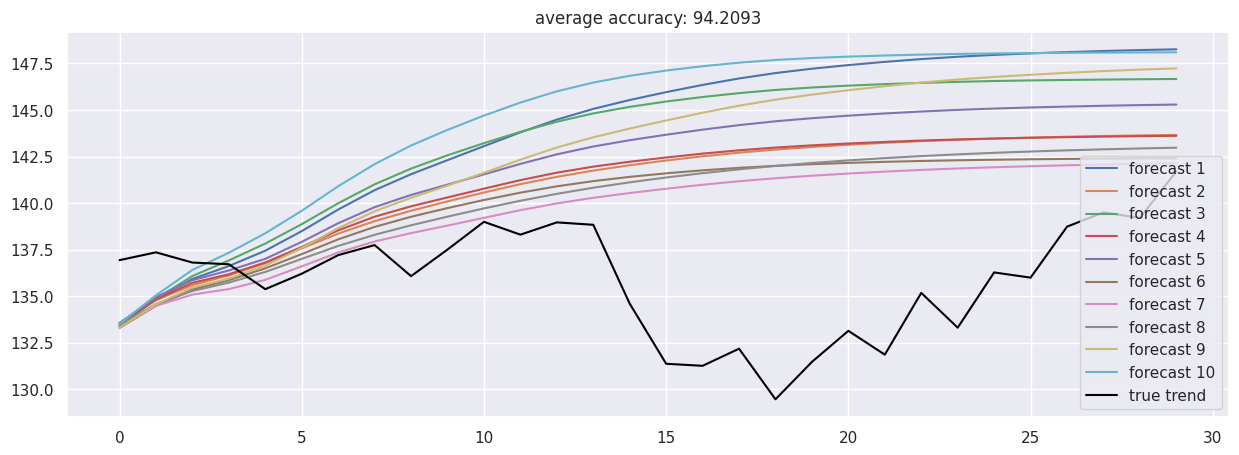

In [ ]:
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()